# Resource vs Utility

Given an application, the latency (utility) of all clients depends on:
  * amount of resources allocated (system determined)
    * how well the application is able to use the allocated resources (OMP_NUM_THREAD): (app determined)
  * number of total clients served by the application (system determined)

The amount of resources allocated consists of the number of cores (**height**) and the amount of cpu shares per core (**width**). The total cpu resources is # cores * cpu shares per core (**area**). If we think of the total amount of cpu resources as a rectangle. The resource allocation carves a shape (a smaller square/rectangle) out of the rectangle. Both the shape and the area of the carved piece matter to applications. For example, an ideal parallizable app has similar utility for a fixed area regardless of the shape. On the other hand, a single thread application, can only take advantages of a smaller rectangle out of a square. Unfortunately, in our set-up, we only have control over the width (cpu shares per core), not the height.

In our setup, we can find the cpu share and the client number that maximize utility.
  * Consider an ideally parallizable job. The more cpu shares we give it, the better the utility (until the total amount of cpu resources becomes larger than the workload). Hence, we want to find the lowest cpu share number that achieves max utility.
  * Now consider an non-ideally parallizable job, which is mostly single-core. It behaves the same as the parallizable job. The more cpu shares we give it, the better the utility (until the total amount of cpu resources becomes larger than the workload).



* Eventually, we want a curve of resource vs utility
* We can get intermediate resource vs latency curve
* multiple ways to convert latency to utility
  * find the average of frame utility
  * take the 90th percentile of frame utility
  
## Optimization problem formulation

* max sum of u(c,m) subject to sum c <= c_total, sum m <= m_total
* the utility function may not be convex, therefore not able to solve it efficiently in polynomial time
* use iterative random search or gradient descent to find local optimal

In [1]:
import sys
import os
# add resource management root dir to python path
sys.path.insert(0, os.path.dirname(os.path.abspath('')))

In [4]:
from __future__ import absolute_import, division, print_function

import matplotlib
rc_fonts = {
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rmexp import dbutils, schema

## Application Latency vs Utility Plot

<IPython.core.display.Javascript object>


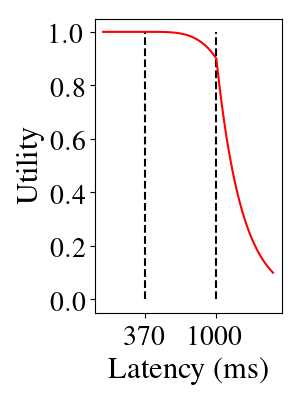

<IPython.core.display.Javascript object>


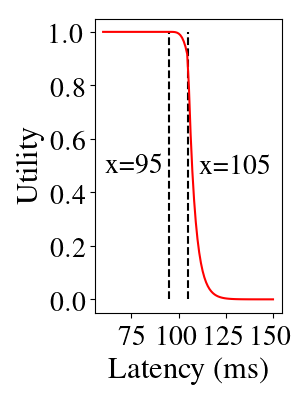

In [57]:
%matplotlib notebook
from rmexp.app_utility_profile import app_default_utility_func

x = np.linspace(0, 1500, 100)
plt.figure(figsize=(3,4))
plt.plot(x, map(app_default_utility_func['face'], x), 'r-')
plt.vlines([370, 1000], 0., 1., linestyles='dashed')
plt.xticks([370, 1000])
plt.xlabel('Latency (ms)', fontsize=22)
plt.ylabel('Utility', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('figs/fig-lat-util-%s.pdf' % 'face', bbox_inches='tight')

x = np.linspace(60, 150, 100)
plt.figure(figsize=(3,4))
plt.plot(x, map(app_default_utility_func['pool'], x), 'r-')
plt.vlines([95, 105], 0., 1., linestyles='dashed')
plt.xlabel('Latency (ms)', fontsize=22)
plt.ylabel('Utility', fontsize=22)
plt.text(0.21, 0.5, 'x=95', fontsize=20, horizontalalignment='center', verticalalignment='center', 
         transform=plt.gca().transAxes)
plt.text(0.75, 0.5, 'x=105', fontsize=20, horizontalalignment='center', verticalalignment='center', 
         transform=plt.gca().transAxes)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('figs/fig-lat-util-%s.pdf' % 'pool', bbox_inches='tight')

## <Allocated CPU, Mem> vs Applicatoin Uility Plot

calculating per second util by each_util * avg_fps


<IPython.core.display.Javascript object>


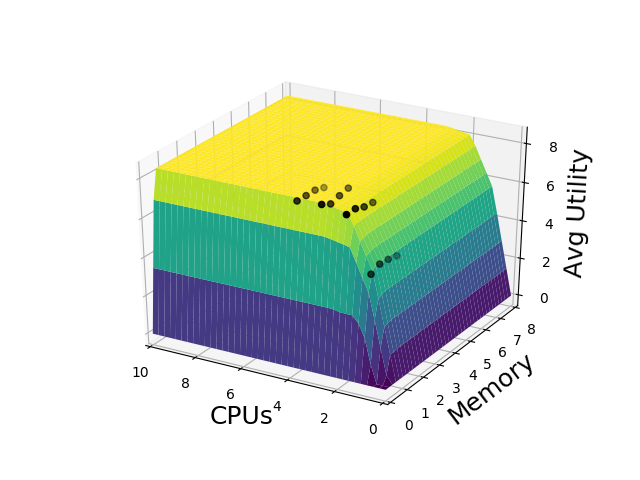

lego Profile
calculating per second util by each_util * avg_fps


<IPython.core.display.Javascript object>


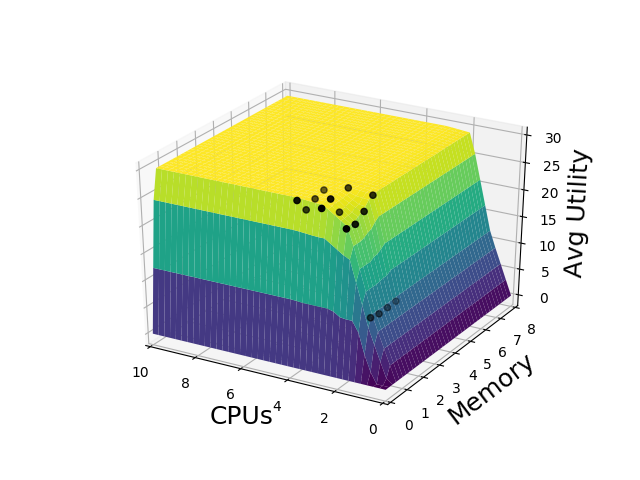

pingpong Profile
calculating per second util by each_util * avg_fps


<IPython.core.display.Javascript object>


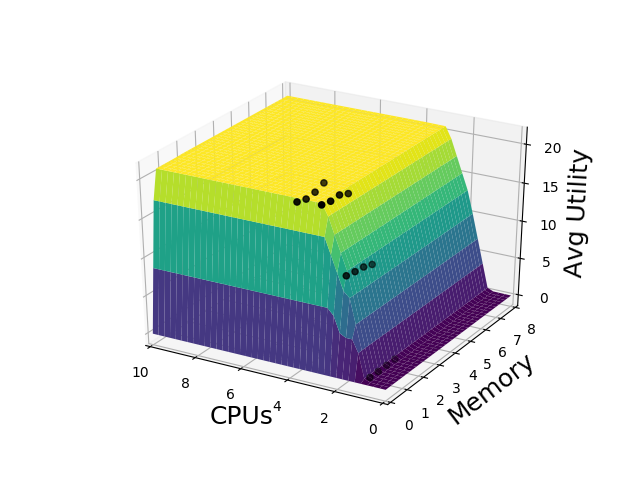

pool Profile
calculating per second util by each_util * avg_fps


<IPython.core.display.Javascript object>


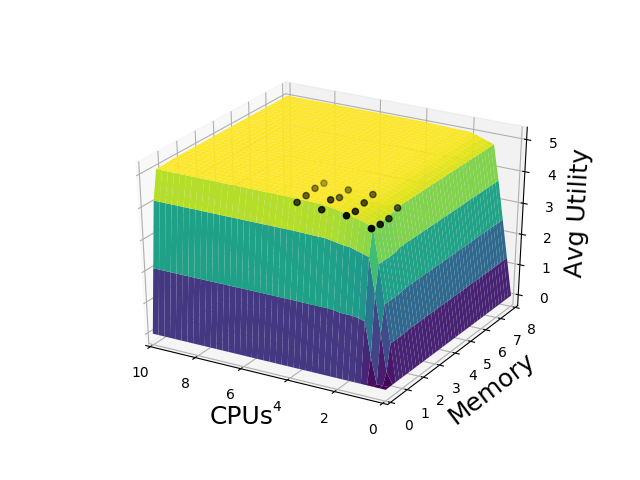

face Profile
calculating per second util by each_util * avg_fps


<IPython.core.display.Javascript object>


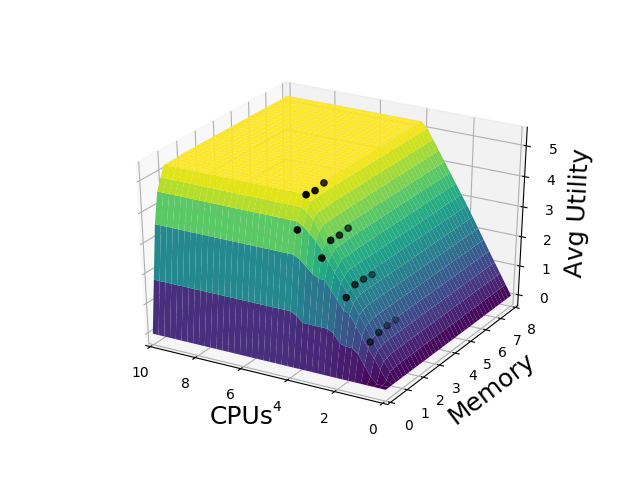

ikea Profile


In [3]:
%matplotlib notebook
from rmexp.profile import ProfileFuncFitter

exp_name = 'c001-cg-wall-w1'
legop = ProfileFuncFitter('lego', exp_name)
pingpongp = ProfileFuncFitter('pingpong', exp_name)
poolp = ProfileFuncFitter('pool', exp_name)
facep = ProfileFuncFitter('face', exp_name)
ikeap = ProfileFuncFitter('ikea', exp_name)

legop.fit_and_plot_profile()
pingpongp.fit_and_plot_profile()
poolp.fit_and_plot_profile()
facep.fit_and_plot_profile()
ikeap.fit_and_plot_profile()

### Save Fitted Functions

In [37]:
# save interpolated func
map(lambda x: x.save_func(), [legop, pingpongp, poolp, facep, ikeap])

[None, None, None, None, None]

### Print Application Profiles

In [46]:
poolp.print_profile()

159.78876945 2.3526938731 112.969324963 -2.12329980683
657.504374695 -0.193646495157 31.6264004335 -1.45224465067
227.326144942 2.13587512615 44.3257277065 -2.61532828331
   mean_latency  cpu  memory
0    185.069721    1       2
1     54.591568    2       2
2     42.363702    4       2
3     48.180192    4       4
4     42.570650    8       2


<IPython.core.display.Javascript object>


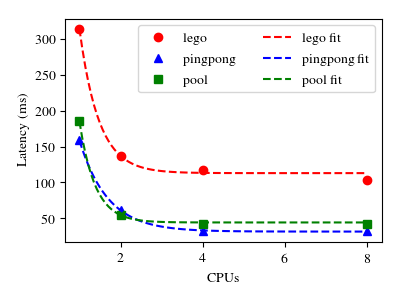

In [50]:
plt.figure(figsize=(4,3))
legop.plot_cpu(plt, fmt='ro')
pingpongp.plot_cpu(plt, fmt='b^')
poolp.plot_cpu(plt, fmt='gs')

# # fit lego
# (a, b, c, d), _ = scipy.optimize.curve_fit(lambda x,a,b,c,d: c*np.exp(-1*(x+a)) +b, legop._df['cpu'].values, legop._df['mean_latency'].values)
# print(a, b, c, d)

x = np.linspace(1, 8, 100)
plt.plot(x, legop(x), 'r--', label='lego fit')
plt.plot(x, pingpongp(x), 'b--', label='pingpong fit')
plt.plot(x, poolp(x), 'g--', label='pool fit')
plt.xlabel('CPUs')
plt.ylabel('Latency (ms)')

plt.legend(ncol=2)
plt.tight_layout()
plt.savefig('fig-res-lat.pdf', bbox_inches='tight')

## Insights into the Original Profiling Data

### CDF of Processing Time Under Different Resource Constraints

5
lego FPS CDF Under Different CPUs, 2G Memory


<IPython.core.display.Javascript object>


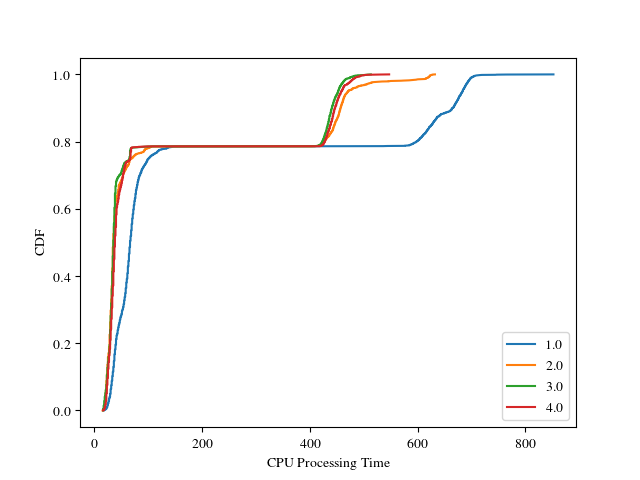

CPU 1.0: 90th percentile latency: 665.0ms
CPU 2.0: 90th percentile latency: 457.0ms
CPU 3.0: 90th percentile latency: 441.0ms
CPU 4.0: 90th percentile latency: 446.0ms
pingpong FPS CDF Under Different CPUs, 2G Memory


/home/junjuew/work/resource-management/conda-env-rmexp/lib/python2.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


<IPython.core.display.Javascript object>


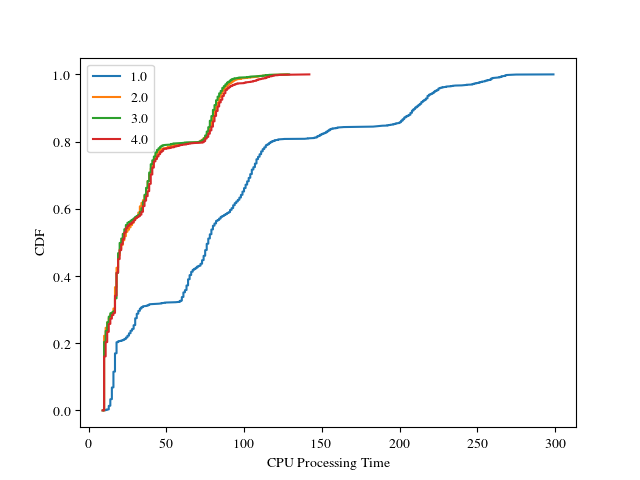

CPU 1.0: 90th percentile latency: 210.0ms
CPU 2.0: 90th percentile latency: 82.0ms
CPU 3.0: 90th percentile latency: 81.0ms
CPU 4.0: 90th percentile latency: 83.0ms
face FPS CDF Under Different CPUs, 2G Memory


<IPython.core.display.Javascript object>


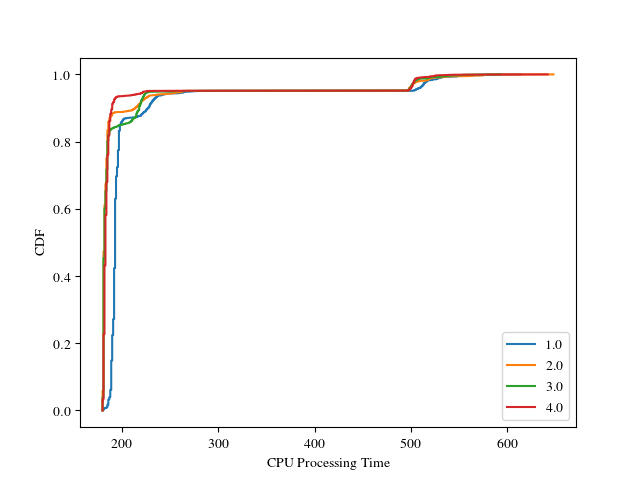

CPU 1.0: 90th percentile latency: 227.7ms
CPU 2.0: 90th percentile latency: 214.0ms
CPU 3.0: 90th percentile latency: 218.0ms
CPU 4.0: 90th percentile latency: 190.0ms
pool FPS CDF Under Different CPUs, 2G Memory


<IPython.core.display.Javascript object>


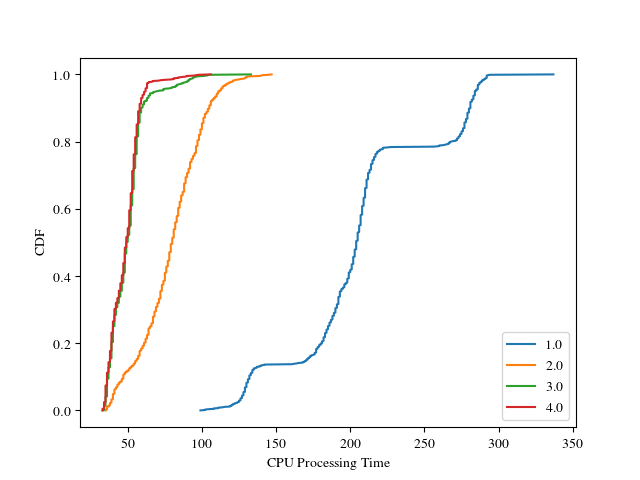

CPU 1.0: 90th percentile latency: 281.0ms
CPU 2.0: 90th percentile latency: 105.0ms
CPU 3.0: 90th percentile latency: 59.0ms
CPU 4.0: 90th percentile latency: 58.0ms
ikea FPS CDF Under Different CPUs, 2G Memory


<IPython.core.display.Javascript object>


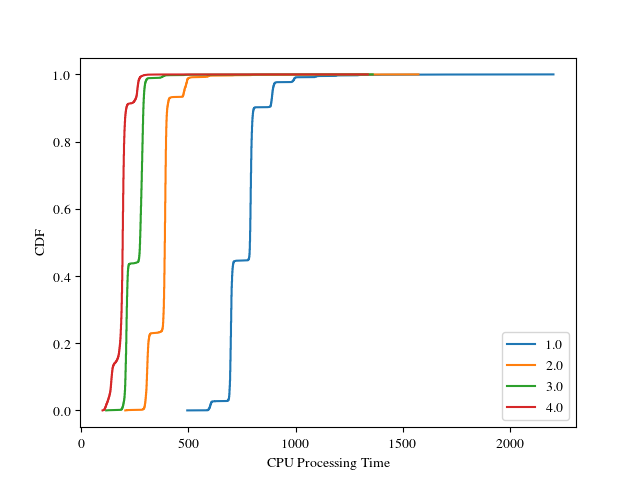

CPU 1.0: 90th percentile latency: 807.5ms
CPU 2.0: 90th percentile latency: 402.0ms
CPU 3.0: 90th percentile latency: 291.0ms
CPU 4.0: 90th percentile latency: 211.0ms


In [28]:
def get_profile(app, exp_name):
    df = pd.read_sql(
        "select latency, cpu, memory, num_worker from ResourceLatency where name=%(exp_name)s and trace like %(app)s",
        schema.engine,
         params={'app': app+'%', 'exp_name': exp_name}
    )
    return df

def plot_cdf(data, label=None):
    plt.plot(np.sort(data), np.linspace(0, 1, len(data)), label=label)

apps = ['lego', 'pingpong', 'face', 'pool', 'ikea']
exps = ['c001-cg-wall-w1'] * len(apps) # wall clock time

profile_latencies = map(lambda x: get_profile(*x), zip(apps, exps))
mem = 2
print(len(profile_latencies))
for idx, profile_latency in enumerate(profile_latencies):
    print('{} FPS CDF Under Different CPUs, {}G Memory'.format(apps[idx], mem))
    plt.figure()
    cpu_latency = profile_latency[profile_latency['memory'] == mem][['cpu', 'latency']]
    groups = cpu_latency.groupby(['cpu'])
    for cpu, group in groups:
        proc_time = group[['latency']]
        print('CPU {}: 90th percentile latency: {}ms'.format(cpu, np.percentile(proc_time, 90)))
        plot_cdf(proc_time.as_matrix().reshape((-1,)), cpu)
    plt.xlabel('Wall Clock Processing Time')
    plt.ylabel('CDF')
    plt.legend()